In [33]:
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Dense,Conv2D, MaxPool2D, Flatten, BatchNormalization, Concatenate, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
set_seed()

# Initializations

In [35]:
input_shape = (227, 227, 3)
diagnostics = False
batch_size=30 # In order to fit the dataset within batch_size, keeping the batch_size as this number
num_classes = 5

Load Data

In [17]:
# Download the dataseet from this link
#!wget http://chaladze.com/l5/img/Linnaeus%205%20256X256.rar


In [18]:
# Make a copy of the dataset in my Google Drive in order to avoid multiple downloads
# This is needed just once
#!cp '/content/Linnaeus 5 256X256.rar' /content/drive/MyDrive/MachineLearning/

# This line is to retrieve the dataset from the Google Drive location into the instance of Colab
!cp '/content/drive/MyDrive/MachineLearning/Linnaeus 5 256X256.rar' '/content/' 

In [19]:
# uncompress the RAR file
get_ipython().system_raw("unrar x '/content/Linnaeus 5 256X256.rar'")

# Loading the Data

In [20]:

path='/content/Linnaeus 5 256X256'
categories = os.listdir(os.path.join(path, 'train'))
if diagnostics: print("categories found =", categories, len(categories))

train_image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(path, 'train')
      , labels='inferred'
      , label_mode='categorical'
      , class_names=categories
      , batch_size=batch_size
      , image_size=(256, 256)
      , shuffle=True
      , seed=2
      , validation_split=0.1
      , subset= 'training'
  )

validation_image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(path, 'train')
      , labels='inferred'
      , label_mode='categorical'
      , class_names=categories
      , batch_size=batch_size
      , image_size=(256, 256)
      , shuffle=True
      , seed=2
      , validation_split=0.1
      , subset= 'validation'
  )


if diagnostics: print("class names found =" , train_image_dataset.class_names)

def crop_images(images, labels):
  '''
  Expecting categories to be names of subfolders and the images belonging to each 
  of the subfolders be stored inside them. While reading the images, they are resized to 256x256x3
  and then cropped to 224x224x3 based on the way the paper describes (randomly between 4 corners and center)
  diagnostics: bool (default False), If True it will print a lot of debug information

  '''
  # In order to clip the image in either from top-left, top-right, bottom-left, bottom-right or center, 
  # we create an array of possible start positions
  corners_list = [0, (256-input_shape[0])//2, 256-input_shape[0]]
  
  # Sampling one number from the list of start positions
  offset_height = offset_width = random.sample(corners_list, 1)[0]
  
  # Standardize the image arrays so that the values fall between +1 and -1
  images = tf.image.per_image_standardization(images-127)
  images = images/tf.math.reduce_max(tf.math.abs(images))
  
  # Crop the image before returning it with the labels
  return  tf.image.crop_to_bounding_box(images, offset_height, offset_width, input_shape[0], input_shape[0]), labels


validation_datasource = validation_image_dataset.map(crop_images)
validation_datasource = validation_datasource.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(batch_size)

datasource = train_image_dataset.map(crop_images)
datasource = datasource.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(batch_size)

#print("len of images", len(images), " labels length =", len(labels), " labels =", labels)
if 1 == 2:
  plt.figure(figsize=(10, 10))
  for images, labels in datasource.take(1):
    for i in range(len(images)):
      print("batch images shape =", images[i].shape)
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i])
      plt.title(image_dataset.class_names[np.argmax(labels[i])] + str(images[i].shape))
      plt.axis("off")

Found 6000 files belonging to 5 classes.
Using 5400 files for training.
Found 6000 files belonging to 5 classes.
Using 600 files for validation.


In [21]:
test_image_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        os.path.join(path, 'test')
      , labels='inferred'
      , label_mode='categorical'
      , class_names=categories
      , batch_size=batch_size
      , image_size=(256, 256)
      , seed=2
  )

test_datasource = test_image_dataset.map(crop_images)
test_datasource = test_datasource.cache().prefetch(buffer_size=tf.data.AUTOTUNE).shuffle(batch_size).repeat()



Found 2000 files belonging to 5 classes.


# Building the AlexNet Model as per paper

Based on https://dl.acm.org/doi/pdf/10.1145/3065386

In [22]:
kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01 )

def conv_block(input, filters, kernel_size, stride = 1
               , kernel_initializer = kernel_initializer
               , bias_initializer = 'zeros'
               , name_suffix='', include_norm = True, include_pool=True, padding='valid'
               , pool_padding='valid', pool_stride = 1, pool_kernel=2):
  
  conv = Conv2D(filters=filters, kernel_size=kernel_size, strides =stride
                   , kernel_initializer=kernel_initializer, padding=padding
                   , bias_initializer=bias_initializer, use_bias=True
                   , activation='elu'
                  , name='conv_'+ name_suffix )(input)
  
  if include_norm:
    norm = BatchNormalization(name='norm_'+ name_suffix)(conv)
  else:
    norm = conv
  if include_pool:
    pool = MaxPool2D(pool_size=pool_kernel, strides=pool_stride
                     , padding=pool_padding
                     , name='pool_'+ name_suffix)(norm)
    return pool
  else:
    return norm


In [23]:


def build_paper_model(optimizer):


  input = Input(shape=input_shape, batch_size = batch_size, name='input_main')

  # First  Layer
  conv_1a = conv_block(input, filters=48, kernel_size=11, stride=4
                      , bias_initializer='zeros', padding = 'valid'
                      , pool_stride= 2, pool_padding='valid', pool_kernel=3
                      , name_suffix='1a')

  conv_1b = conv_block(input, filters=48, kernel_size=11, stride=4
                      , bias_initializer='zeros', padding = 'valid'
                      , pool_stride= 2, pool_padding='valid', pool_kernel=3
                      , name_suffix='1b')

  # Second  Layer
  conv_2a = conv_block(conv_1a, filters = 128, kernel_size = 5, stride = 1
                      , bias_initializer='ones', padding='same'
                      , pool_stride=2, pool_kernel=3
                      , name_suffix = '2a')

  conv_2b = conv_block(conv_1b, filters = 128, kernel_size = 5, stride = 1
                      , bias_initializer='ones', padding='same'
                      , pool_stride = 2, pool_kernel=3
                      , name_suffix = '2b')

  # Third  Layer 
  concatenate = Concatenate(axis=-1, name='concatenate')([conv_2a, conv_2b])
  conv_3a = conv_block(concatenate, filters = 192, kernel_size = 3, stride = 1
                      , padding='same', bias_initializer='zeros'
                      , name_suffix = '3a'
                      ,include_norm = False, include_pool=False)

  conv_3b = conv_block(concatenate, filters = 192, kernel_size = 3, stride = 1
                      , padding='same', bias_initializer='zeros'
                      , name_suffix = '3b'
                      ,include_norm = False, include_pool=False)

  # Fourth Layer
  conv_4a = conv_block(conv_3a, filters = 192, kernel_size = 3, stride = 1
                      , padding='same'
                      , bias_initializer='ones', name_suffix = '4a'
                      ,include_norm = False, include_pool=False)

  conv_4b = conv_block(conv_3b, filters = 192, kernel_size = 3, stride = 1
                      , padding='same'
                      , bias_initializer='ones', name_suffix = '4b'
                      ,include_norm = False, include_pool=False)

  # Fifth Layer
  conv_5a = conv_block(conv_4a, filters = 128, kernel_size = 3, stride = 1
                      , bias_initializer='ones', padding='same'
                      , pool_stride = 2, pool_kernel = 3
                      , name_suffix = '5a'
                      ,include_norm = False, include_pool=True)

  conv_5b = conv_block(conv_4b, filters = 128, kernel_size = 3, stride = 1
                      , bias_initializer='ones', padding='same'
                      , pool_stride = 2, pool_kernel = 3
                      ,  name_suffix = '5b'
                      ,include_norm = False, include_pool=True)
  # Sixth Layer (FC1)
  concatenate_fc_1 = Concatenate( name='concatenate_fc_1')([conv_5a, conv_5b])
  flatten_fc_1 = Flatten(name='flatten_fc_1')(concatenate_fc_1)
  fc_1 = Dense(4096, activation='elu', kernel_initializer=kernel_initializer
                , bias_initializer='ones', name='fc_1')(flatten_fc_1)
  dropout_1 =Dropout(0.4, name='dropout_1')(fc_1)
  # Seventh Layer (FC2)
  fc_2 = Dense(4096, activation='elu', kernel_initializer=kernel_initializer
                , bias_initializer='ones', name='fc_2')(dropout_1)
  dropout_2 =Dropout(0.4, name='dropout_2')(fc_2)
  # Output layer
  output = Dense(len(categories), activation='softmax'
            , kernel_initializer=kernel_initializer
            , bias_initializer='ones', name='output')(dropout_2)

  model = Model(inputs=input, outputs = output)

  model.summary()
  
  model.compile(optimizer = optimizer, loss='categorical_crossentropy'
                ,metrics=['accuracy']  )
  return model

## Learning Rate Manipulation
As per the paper, LR is divided by 10 everytime if there is either no change in or increase of the error rate. Here instead of the validation error rate, we will use the validation loss to make this change

In [24]:
sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=False, name='SGD')


## Callback Functions

In [25]:
# Saving the model when we reach a good min loss valid
def callbacks(checkpoint_filename):
  model_checkpoint = ModelCheckpoint(filepath=checkpoint_filename,
                                    monitor='val_loss',
                                    save_best_only=True,
                                    save_weights_only=False,
                                    mode='auto',
                                    save_freq='epoch',
                                    verbose = 1)

  early_stopping = EarlyStopping(monitor='val_loss',
                                min_delta=0.0001,
                                restore_best_weights = True,
                                patience=10,
                                verbose = 1
                                )

  reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                          factor=0.1,
                                          patience=3,
                                          mode ='min',
                                          min_delta=0.001,
                                          min_lr=1e-8,
                                          verbose = 1)


  return [model_checkpoint, early_stopping, reduce_learning_rate]

## Training the Model

In [26]:
paper_model = build_paper_model(sgd)

paper_model.compile(optimizer=sgd
                    , loss='categorical_crossentropy'
                    , metrics=['categorical_accuracy'] )


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_main (InputLayer)         [(30, 227, 227, 3)]  0                                            
__________________________________________________________________________________________________
conv_1a (Conv2D)                (30, 55, 55, 48)     17472       input_main[0][0]                 
__________________________________________________________________________________________________
conv_1b (Conv2D)                (30, 55, 55, 48)     17472       input_main[0][0]                 
__________________________________________________________________________________________________
norm_1a (BatchNormalization)    (30, 55, 55, 48)     192         conv_1a[0][0]                    
____________________________________________________________________________________________

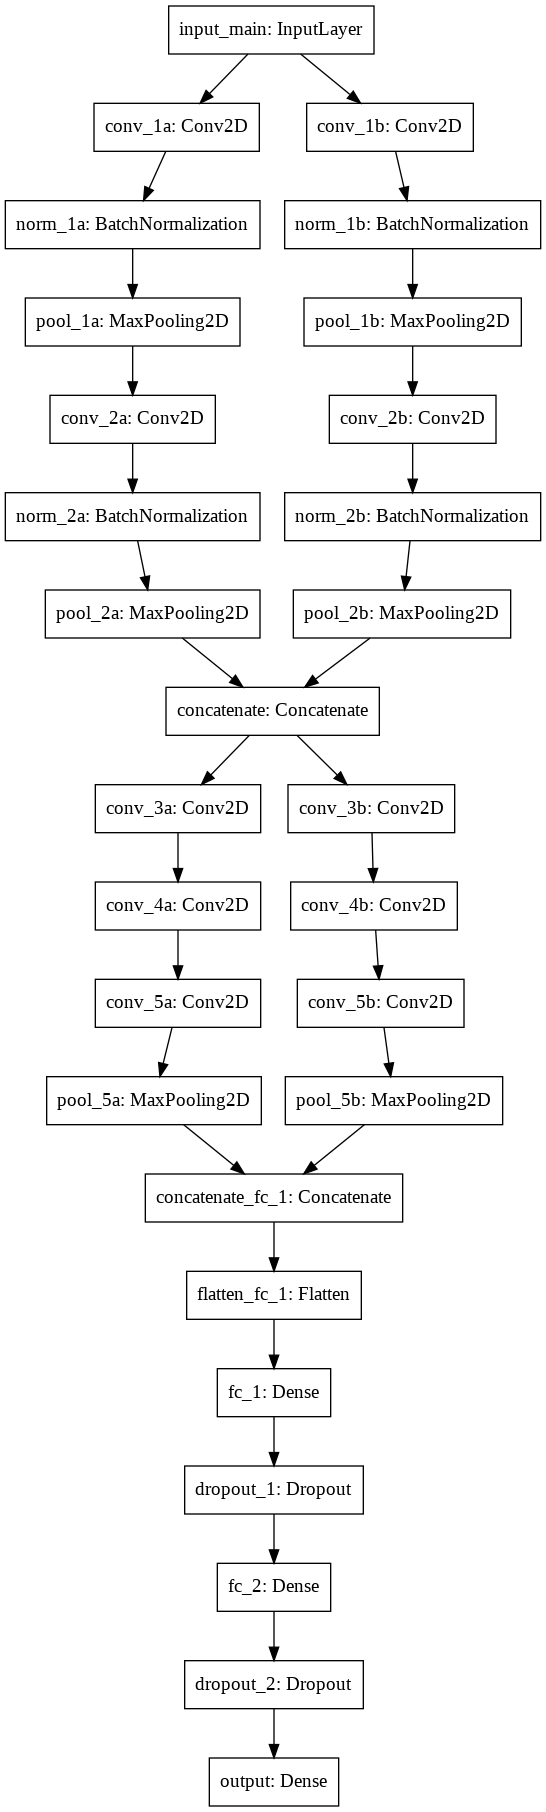

In [27]:
tf.keras.utils.plot_model(paper_model)

In [28]:
metrics = paper_model.fit(datasource
                , epochs = 50
                , validation_data = validation_datasource
                , callbacks = callbacks('alexnet_paper.h5')
                )


Epoch 1/50
180/180 [==============================] - 29s 137ms/step - loss: 2.1207 - categorical_accuracy: 0.2404 - val_loss: 1.8574 - val_categorical_accuracy: 0.2283

Epoch 00001: val_loss improved from inf to 1.85744, saving model to alexnet_paper.h5
Epoch 2/50
180/180 [==============================] - 20s 112ms/step - loss: 1.5175 - categorical_accuracy: 0.3717 - val_loss: 2.0989 - val_categorical_accuracy: 0.2500

Epoch 00002: val_loss did not improve from 1.85744
Epoch 3/50
180/180 [==============================] - 20s 109ms/step - loss: 1.3071 - categorical_accuracy: 0.4670 - val_loss: 1.3357 - val_categorical_accuracy: 0.4583

Epoch 00003: val_loss improved from 1.85744 to 1.33571, saving model to alexnet_paper.h5
Epoch 4/50
180/180 [==============================] - 20s 110ms/step - loss: 1.1838 - categorical_accuracy: 0.5246 - val_loss: 1.0990 - val_categorical_accuracy: 0.5717

Epoch 00004: val_loss improved from 1.33571 to 1.09901, saving model to alexnet_paper.h5
Epoch 

### Loss and Accuracy Plots

Text(0.5, 1.0, 'Accuracy')

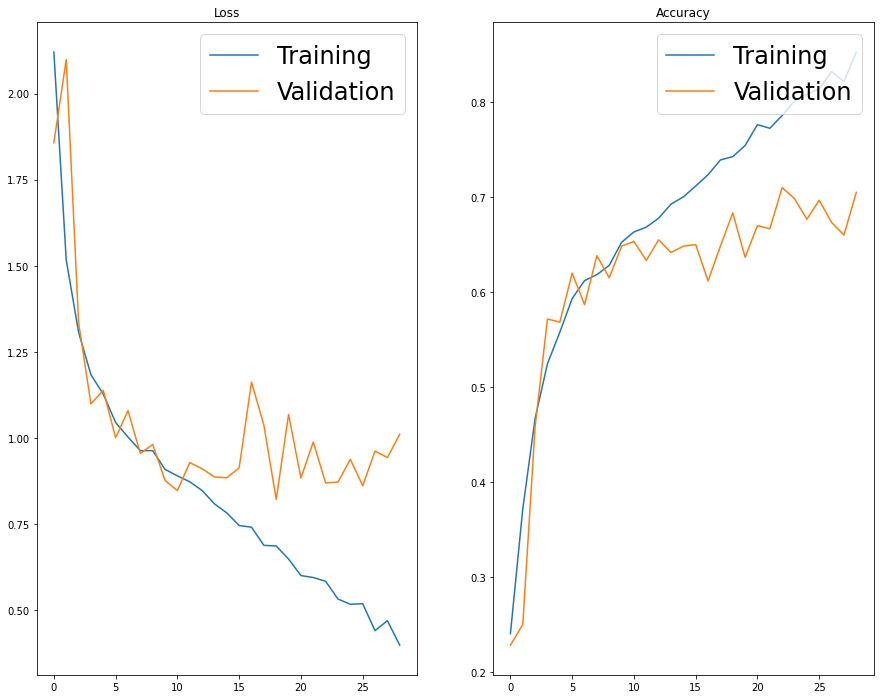

In [29]:
plt.figure(figsize=(15,12))

plt.subplot(1,2,1)
plt.plot(metrics.history['loss'], label='Training')
plt.plot(metrics.history['val_loss'], label='Validation')
plt.legend(loc='upper right', prop={'size': 24});
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(metrics.history['categorical_accuracy'], label='Training')
plt.plot(metrics.history['val_categorical_accuracy'], label='Validation')
plt.legend(loc='upper right', prop={'size': 24});
plt.title('Accuracy')

In [30]:
!cp /content/alexnet_paper.h5 '/content/drive/MyDrive/MachineLearning/'

### Testing the model with unseen data

In [31]:
predictions = []
actuals=[]

for i, (images, labels) in enumerate( test_datasource):
  if i > 20:
    break
  pred = paper_model(images)
  for j in range(len(labels)):
    actuals.append( labels[j])
    predictions.append(pred[j])

print("number of labels =", len(labels), " predictions =", len(predictions))
# Printing a few labels and predictions to ensure that there are no dead-Relus
for j in range(10):
  print(labels[j].numpy(), "\t", pred[j].numpy())

number of labels = 30  predictions = 630
[1. 0. 0. 0. 0.] 	 [0.08173203 0.7897602  0.016753   0.08914992 0.02260488]
[0. 0. 0. 1. 0.] 	 [0.06361729 0.58453476 0.32959747 0.01876925 0.00348123]
[0. 1. 0. 0. 0.] 	 [0.00546556 0.09751061 0.00508122 0.02210991 0.8698327 ]
[0. 1. 0. 0. 0.] 	 [0.90424055 0.07209997 0.01203938 0.00693696 0.00468307]
[0. 0. 0. 0. 1.] 	 [0.13888402 0.7828434  0.03301512 0.02366349 0.02159404]
[0. 0. 0. 1. 0.] 	 [0.5052219  0.41522014 0.02559812 0.03034243 0.02361743]
[0. 0. 0. 0. 1.] 	 [0.245792   0.7332937  0.00845792 0.00885298 0.00360343]
[0. 1. 0. 0. 0.] 	 [0.26673472 0.42051432 0.02742668 0.2086614  0.07666277]
[1. 0. 0. 0. 0.] 	 [0.10550564 0.21499118 0.01909858 0.6102387  0.05016592]
[0. 1. 0. 0. 0.] 	 [0.6888244  0.14237967 0.0229404  0.01474907 0.13110642]


### Confusion Matrix

In [36]:
pd.DataFrame(tf.math.confusion_matrix(
    np.argmax(actuals, axis=1), np.argmax(predictions, axis=1), num_classes=num_classes, dtype=tf.dtypes.int32).numpy()
    , columns = test_image_dataset.class_names
    , index =  test_image_dataset.class_names)

,other,bird,dog,berry,flower
other,82,39,7,8,3
bird,15,94,14,7,3
dog,6,28,82,2,1
berry,9,16,4,87,8
flower,3,16,1,11,84


# Model with Textbook Architecture

In [104]:

def textbook_paper_cross_model():
  input = Input(shape=input_shape, batch_size = batch_size, name='input_main')

  # First  Layer
  conv_1a = conv_block(input, filters=96, kernel_size=11, stride=4
                      , bias_initializer='zeros', padding = 'valid'
                      , pool_stride= 1, pool_padding='same'
                      , name_suffix='1a')

  # Second  Layer
  conv_2a = conv_block(conv_1a, filters = 256, kernel_size = 5, stride = 1
                      , bias_initializer='ones', padding='same'
                      , pool_stride=2, pool_kernel=2
                      , name_suffix = '2a')

  # Third  Layer 
  conv_3a = conv_block(conv_2a, filters = 384, kernel_size = 3, stride = 2
                      , padding='valid', bias_initializer='zeros'
                      , name_suffix = '3a'
                      ,include_norm = False, include_pool=False)

  # Fourth Layer
  conv_4a = conv_block(conv_3a, filters = 384, kernel_size = 3, stride = 1
                      , padding='same'
                      , bias_initializer='ones', name_suffix = '4a'
                      ,include_norm = False, include_pool=False)

  # Fifth Layer
  conv_5a = conv_block(conv_4a, filters = 256, kernel_size = 3, stride = 1
                      , bias_initializer='ones'
                      , padding='same'
                      , pool_stride = 1, pool_kernel = 2
                      , name_suffix = '5a'
                      ,include_norm = False, include_pool=True)
  # Sixth Layer (FC1)
  flatten_fc_1 = Flatten(name='flatten_fc_1')(conv_5a)
  fc_1 = Dense(2048, activation='elu', kernel_initializer=kernel_initializer
                , bias_initializer='ones', name='fc_1')(flatten_fc_1)
  dropout_1 =Dropout(0.5, name='dropout_1')(fc_1)
  # Seventh Layer (FC2)
  fc_2 = Dense(2048, activation='elu', kernel_initializer=kernel_initializer
                , bias_initializer='ones', name='fc_2')(dropout_1)
  dropout_2 =Dropout(0.5, name='dropout_2')(fc_2)
  # Output layer
  output = Dense(len(categories), activation='softmax'
            , kernel_initializer=kernel_initializer
            , bias_initializer='ones', name='output')(dropout_2)

  model = Model(inputs=input, outputs = output, name='single_channel_alexnet')

  model.summary()
  return model

In [107]:
sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=False, name='SGD')
single_channel_alexnet = textbook_paper_cross_model()
single_channel_alexnet.compile(optimizer = sgd 
                               , loss = 'categorical_crossentropy'
                               , metrics =['categorical_accuracy']
                               )

Model: "single_channel_alexnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_main (InputLayer)      [(30, 227, 227, 3)]       0         
_________________________________________________________________
conv_1a (Conv2D)             (30, 55, 55, 96)          34944     
_________________________________________________________________
norm_1a (BatchNormalization) (30, 55, 55, 96)          384       
_________________________________________________________________
pool_1a (MaxPooling2D)       (30, 55, 55, 96)          0         
_________________________________________________________________
conv_2a (Conv2D)             (30, 55, 55, 256)         614656    
_________________________________________________________________
norm_2a (BatchNormalization) (30, 55, 55, 256)         1024      
_________________________________________________________________
pool_2a (MaxPooling2D)       (30, 27, 27, 25

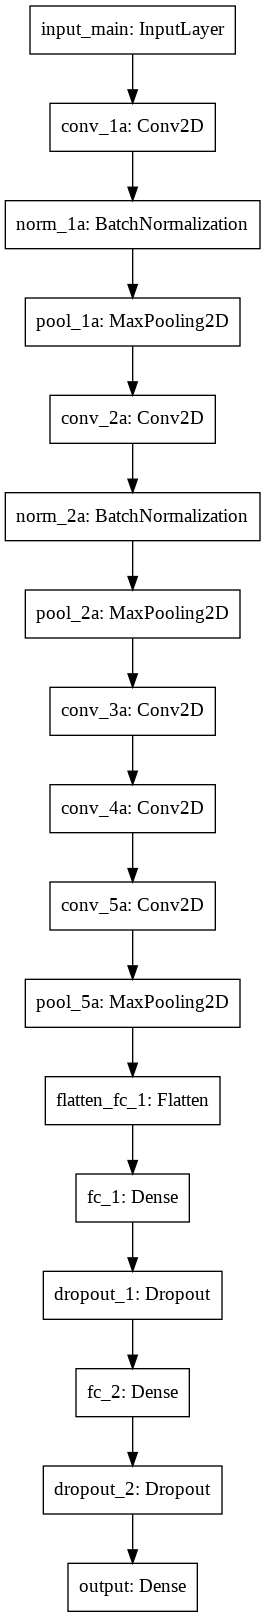

In [108]:
tf.keras.utils.plot_model(single_channel_alexnet)

## Training the Model

In [109]:
metrics = single_channel_alexnet.fit(datasource
                    , epochs = 50
                    , validation_data = validation_datasource
                    , validation_steps = 5
                    , callbacks=callbacks('single_channel_alexnet.h5'))

Epoch 1/50
180/180 [==============================] - 36s 190ms/step - loss: 1.8748 - categorical_accuracy: 0.2754 - val_loss: 1.6872 - val_categorical_accuracy: 0.3133

Epoch 00001: val_loss improved from inf to 1.68724, saving model to single_channel_alexnet.h5
Epoch 2/50
180/180 [==============================] - 34s 191ms/step - loss: 1.4830 - categorical_accuracy: 0.3907 - val_loss: 1.9494 - val_categorical_accuracy: 0.2067

Epoch 00002: val_loss did not improve from 1.68724
Epoch 3/50
180/180 [==============================] - 34s 191ms/step - loss: 1.3749 - categorical_accuracy: 0.4396 - val_loss: 1.3501 - val_categorical_accuracy: 0.4600

Epoch 00003: val_loss improved from 1.68724 to 1.35013, saving model to single_channel_alexnet.h5
Epoch 4/50
180/180 [==============================] - 34s 191ms/step - loss: 1.2977 - categorical_accuracy: 0.4789 - val_loss: 1.2322 - val_categorical_accuracy: 0.5400

Epoch 00004: val_loss improved from 1.35013 to 1.23223, saving model to singl

### Loss and Accuracy Plots

Text(0.5, 1.0, 'Accuracy')

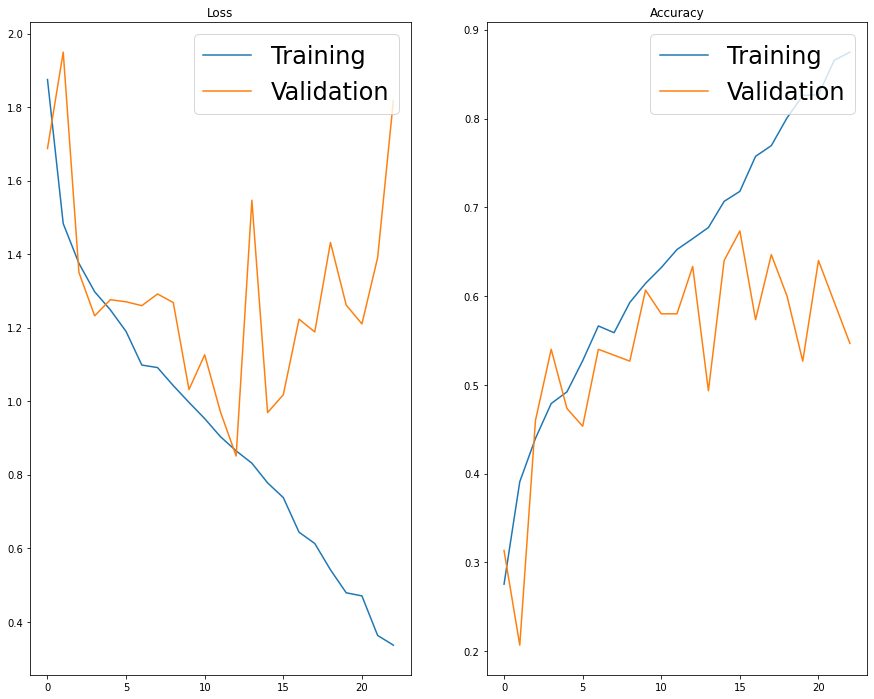

In [110]:
plt.figure(figsize=(15,12))

plt.subplot(1,2,1)
plt.plot(metrics.history['loss'], label='Training')
plt.plot(metrics.history['val_loss'], label='Validation')
plt.legend(loc='upper right', prop={'size': 24});
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(metrics.history['categorical_accuracy'], label='Training')
plt.plot(metrics.history['val_categorical_accuracy'], label='Validation')
plt.legend(loc='upper right', prop={'size': 24});
plt.title('Accuracy')

### Test the model with unseen data

In [111]:
predictions = []
actuals=[]

for i, (images, labels) in enumerate( test_datasource):
  if i > 20:
    break
  pred = single_channel_alexnet(images)
  for j in range(len(labels)):
    actuals.append( labels[j])
    predictions.append(pred[j])

print("number of labels =", len(labels), " predictions =", len(predictions))
# Printing a few labels and predictions to ensure that there are no dead-Relus
for j in range(10):
  print(labels[j].numpy(), "\t", pred[j].numpy())

number of labels = 30  predictions = 630
[0. 1. 0. 0. 0.] 	 [0.6153772  0.17644875 0.17673886 0.0254489  0.00598634]
[0. 1. 0. 0. 0.] 	 [7.4747331e-03 2.2292713e-04 1.1110649e-04 9.9133646e-01 8.5474760e-04]
[0. 0. 0. 1. 0.] 	 [3.8074080e-02 9.4890684e-01 1.1695264e-02 7.4980530e-04 5.7397096e-04]
[1. 0. 0. 0. 0.] 	 [0.3734964  0.39838132 0.12912066 0.03311019 0.06589139]
[0. 0. 1. 0. 0.] 	 [0.38722047 0.30608854 0.08821187 0.1525347  0.06594445]
[0. 0. 0. 1. 0.] 	 [0.35085475 0.23500866 0.00540964 0.00521133 0.40351567]
[0. 0. 1. 0. 0.] 	 [6.3856565e-03 3.2050540e-03 1.8102107e-04 1.4662106e-01 8.4360719e-01]
[0. 0. 0. 0. 1.] 	 [7.6085874e-03 3.3576908e-03 4.2298983e-05 7.0757401e-01 2.8141752e-01]
[0. 0. 1. 0. 0.] 	 [8.5151333e-01 1.4722311e-01 8.8536361e-04 3.4501782e-04 3.3172430e-05]
[0. 0. 0. 1. 0.] 	 [0.0434675  0.22383413 0.02104767 0.47587729 0.23577337]


### Confusion Matrix

In [112]:
pd.DataFrame(tf.math.confusion_matrix(
    np.argmax(actuals, axis=1), np.argmax(predictions, axis=1), num_classes=num_classes, dtype=tf.dtypes.int32).numpy()
    , columns = test_image_dataset.class_names
    , index =  test_image_dataset.class_names)

,other,bird,dog,berry,flower
other,92,13,17,6,13
bird,31,63,19,2,14
dog,12,15,90,1,4
berry,13,11,13,58,18
flower,11,4,7,11,92


In [113]:
!cp /content/single_channel_alexnet.h5 '/content/drive/MyDrive/MachineLearning/'

## From Textbook

In [114]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense,Activation,MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2

In [115]:
# Instantiate an empty sequential model
model = Sequential(name="Alexnet")
# 1st layer (conv + pool + batchnorm)
model.add(Conv2D(filters= 96, kernel_size= (11,11), strides=(4,4), padding='valid', kernel_regularizer=l2(0.0005),
input_shape = (227,227,3)))
model.add(Activation('elu'))  #<---- activation function can be added on its own layer or within the Conv2D function
model.add(MaxPool2D(pool_size=(3,3), strides= (2,2), padding='valid'))
model.add(BatchNormalization())
    
# 2nd layer (conv + pool + batchnorm)
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
model.add(Activation('elu'))
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))
model.add(BatchNormalization())
            
# layer 3 (conv + batchnorm)      <--- note that the authors did not add a POOL layer here
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
model.add(Activation('elu'))
model.add(BatchNormalization())
        
# layer 4 (conv + batchnorm)      <--- similar to layer 3
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
model.add(Activation('elu'))
model.add(BatchNormalization())
            
# layer 5 (conv + batchnorm)  
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', kernel_regularizer=l2(0.0005)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(3,3), strides=(2,2), padding='valid'))

# Flatten the CNN output to feed it with fully connected layers
model.add(Flatten())

# layer 6 (Dense layer + dropout)  
model.add(Dense(units = 4096, activation = 'elu'))
model.add(Dropout(0.5))

# layer 7 (Dense layers) 
model.add(Dense(units = 4096, activation = 'elu'))
model.add(Dropout(0.5))
                           
# layer 8 (softmax output layer) 
model.add(Dense(units = 5, activation = 'softmax'))

# print the model summary
model.summary()


Model: "Alexnet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
activation (Activation)      (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
activation_1 (Activation)    (None, 27, 27, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0   

## Training the model

In [116]:
sgd = SGD(learning_rate=0.001, momentum=0.9, nesterov=False, name='SGD')
model.compile(optimizer=sgd
              , loss='categorical_crossentropy'
              , metrics=['categorical_accuracy']
              )

In [117]:
metrics = model.fit(datasource, epochs=50
          ,validation_steps = 20
          , shuffle = True
          ,validation_data=validation_datasource
          ,  callbacks=callbacks('alexnet_pure_textbook.h5')
          )

Epoch 1/50
180/180 [==============================] - 22s 114ms/step - loss: 3.9187 - categorical_accuracy: 0.3626 - val_loss: 4.8489 - val_categorical_accuracy: 0.2983

Epoch 00001: val_loss improved from inf to 4.84893, saving model to alexnet_pure_textbook.h5
Epoch 2/50
180/180 [==============================] - 20s 112ms/step - loss: 2.6356 - categorical_accuracy: 0.4600 - val_loss: 3.0160 - val_categorical_accuracy: 0.3933

Epoch 00002: val_loss improved from 4.84893 to 3.01601, saving model to alexnet_pure_textbook.h5
Epoch 3/50
180/180 [==============================] - 20s 112ms/step - loss: 2.2261 - categorical_accuracy: 0.5070 - val_loss: 2.2346 - val_categorical_accuracy: 0.4833

Epoch 00003: val_loss improved from 3.01601 to 2.23464, saving model to alexnet_pure_textbook.h5
Epoch 4/50
180/180 [==============================] - 20s 112ms/step - loss: 2.0255 - categorical_accuracy: 0.5365 - val_loss: 2.1092 - val_categorical_accuracy: 0.5200

Epoch 00004: val_loss improved fr

### Loss and Accuracy Plots

Text(0.5, 1.0, 'Accuracy')

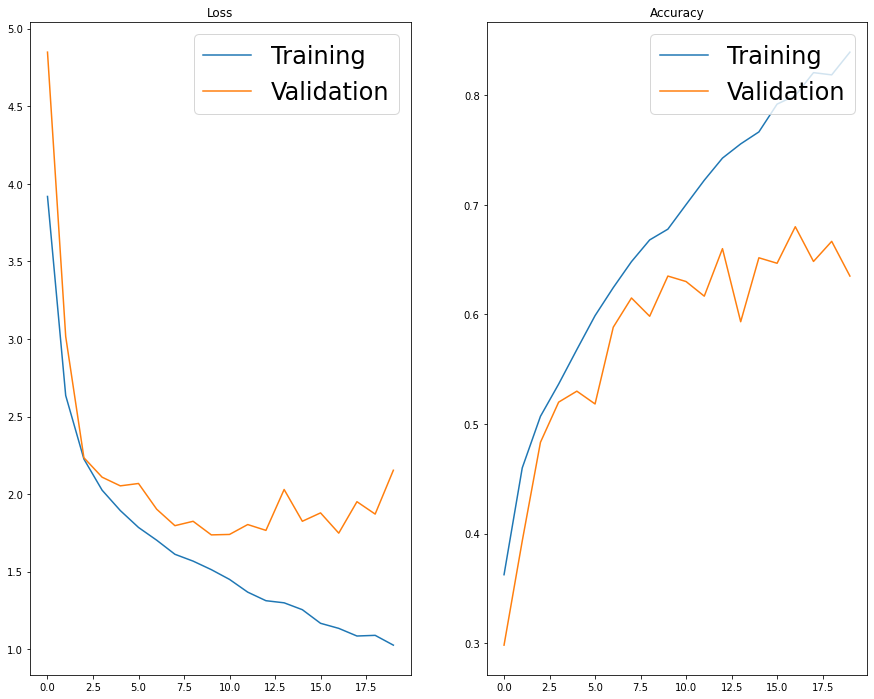

In [118]:
plt.figure(figsize=(15,12))

plt.subplot(1,2,1)
plt.plot(metrics.history['loss'], label='Training')
plt.plot(metrics.history['val_loss'], label='Validation')
plt.legend(loc='upper right', prop={'size': 24});
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(metrics.history['categorical_accuracy'], label='Training')
plt.plot(metrics.history['val_categorical_accuracy'], label='Validation')
plt.legend(loc='upper right', prop={'size': 24});
plt.title('Accuracy')

### Testing the model with unseeen data

In [119]:
predictions = []
actuals=[]

for i, (images, labels) in enumerate( test_datasource):
  if i > 20:
    break
  pred = model(images)
  for j in range(len(labels)):
    actuals.append( labels[j])
    predictions.append(pred[j])

print("number of labels =", len(labels), " predictions =", len(predictions))
# Printing a few labels and predictions to ensure that there are no dead-Relus
for j in range(10):
  print(labels[j].numpy(), "\t", pred[j].numpy())

number of labels = 30  predictions = 630
[0. 0. 0. 1. 0.] 	 [0.9458113  0.03483459 0.01167393 0.00292123 0.00475898]
[0. 0. 0. 0. 1.] 	 [0.06571516 0.815135   0.08224288 0.00923114 0.0276759 ]
[0. 0. 0. 0. 1.] 	 [9.10720289e-01 7.41442293e-02 8.58633779e-04 1.42579805e-02
 1.87640617e-05]
[0. 0. 0. 1. 0.] 	 [0.0010596  0.06003032 0.07360905 0.00377185 0.8615292 ]
[1. 0. 0. 0. 0.] 	 [0.17285554 0.6676567  0.15097025 0.00660795 0.00190955]
[0. 0. 0. 0. 1.] 	 [0.00704761 0.0028238  0.09823276 0.89066744 0.00122851]
[0. 0. 0. 1. 0.] 	 [0.0177269  0.32234702 0.6132529  0.04466769 0.00200551]
[0. 0. 0. 1. 0.] 	 [0.00404334 0.04872768 0.01249785 0.03147859 0.9032526 ]
[0. 0. 1. 0. 0.] 	 [0.01091205 0.19341655 0.0942476  0.66117746 0.04024632]
[0. 0. 0. 1. 0.] 	 [6.0277735e-03 2.8815234e-04 5.2092353e-05 9.9322355e-01 4.0847689e-04]


### Confusion Matrix

In [120]:
pd.DataFrame(tf.math.confusion_matrix(
    np.argmax(actuals, axis=1), np.argmax(predictions, axis=1), num_classes=num_classes, dtype=tf.dtypes.int32).numpy()
    , columns = test_image_dataset.class_names
    , index =  test_image_dataset.class_names)

,other,bird,dog,berry,flower
other,94,8,14,10,10
bird,31,43,30,9,10
dog,18,8,93,2,2
berry,18,8,4,65,24
flower,11,10,8,13,87


In [121]:
!cp /content/alexnet_pure_textbook.h5 '/content/drive/MyDrive/MachineLearning/'

## Training the model with custom training (TBD)